This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [1]:
import tensorflow as tf

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", tf.keras.__version__)
print("Tensorflow: ", tf.__version__)


Python:  3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas:  0.25.1
numpy:  1.17.2
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.21.3
Keras:  2.2.4-tf
Tensorflow:  2.0.0-rc1


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            x = group.index.values
            y = group.error
            axes.plot(x, y, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:

tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']




In [4]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [5]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
df['Datetime'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['hour'] = df['Datetime'].dt.hour
#df['hour'] = [1 if (ele >= 8 and ele < 20) else 0 for ele in df["hour"]]


df = df[(df.Datetime > '2014-08-01') & (df.Datetime < '2015-01-30')]
df = df.reset_index(drop=True)
print(df.shape)
print(df.head(5))
training_points = 4000

Shape: 10320
Head:
(8735, 6)
             timestamp  value            Datetime  dayofweek  month  hour
0  2014-08-01 00:30:00  17252 2014-08-01 00:30:00          4      8     0
1  2014-08-01 01:00:00  14103 2014-08-01 01:00:00          4      8     1
2  2014-08-01 01:30:00  10859 2014-08-01 01:30:00          4      8     1
3  2014-08-01 02:00:00   9242 2014-08-01 02:00:00          4      8     2
4  2014-08-01 02:30:00   7122 2014-08-01 02:30:00          4      8     2


Text(0.5, 1.0, 'Time Series of value by date time')

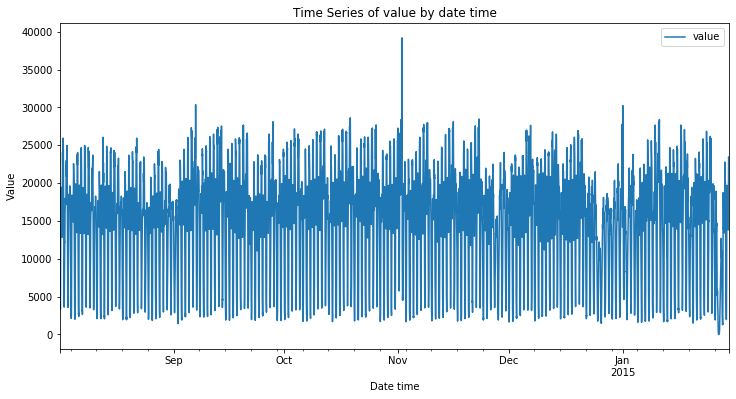

In [6]:
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0, 0.5, 'correlation coeff')

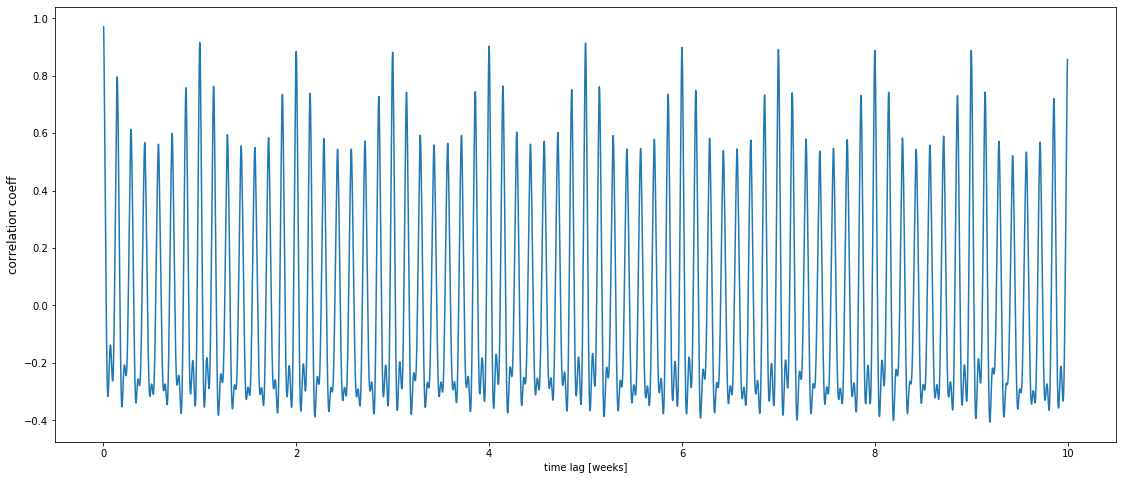

In [7]:
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lag [weeks]')
plt.ylabel('correlation coeff', fontsize=12)

Text(0.5, 1.0, 'Time Series of value by date time')

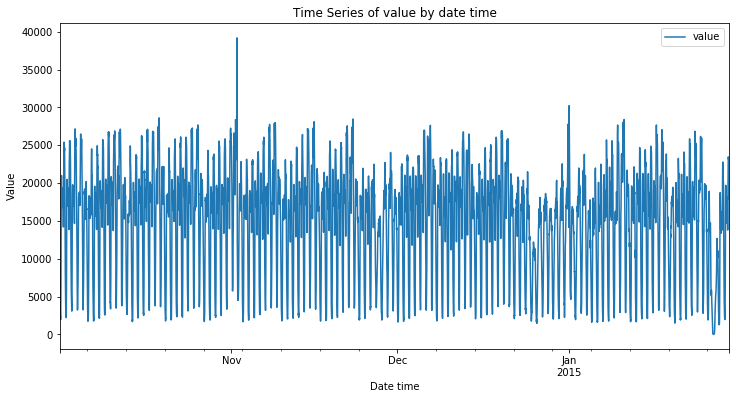

In [8]:
df2 = df[(df.Datetime > '2014-10-01') & (df.Datetime < '2015-01-30')]
df2.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0.5, 1.0, 'Time Series of value by date time')

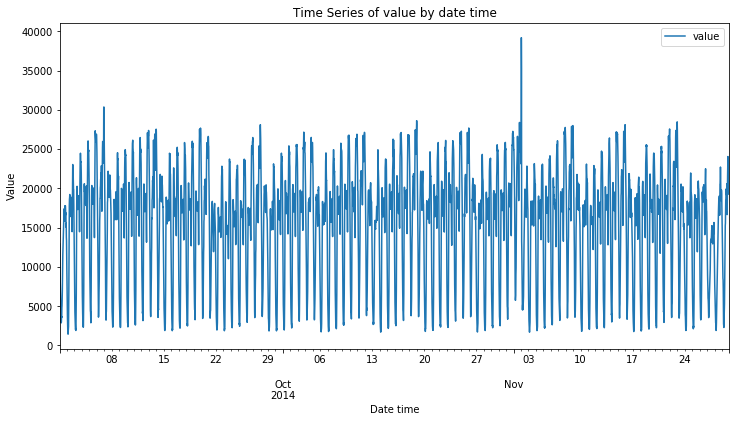

In [9]:
df2 = df[(df.Datetime > '2014-09-01') & (df.Datetime < '2014-11-30')]
df2.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [10]:
df.value.describe()

count     8735.000000
mean     15133.392444
std       6962.205342
min          8.000000
25%      10172.000000
50%      16790.000000
75%      19879.000000
max      39197.000000
Name: value, dtype: float64

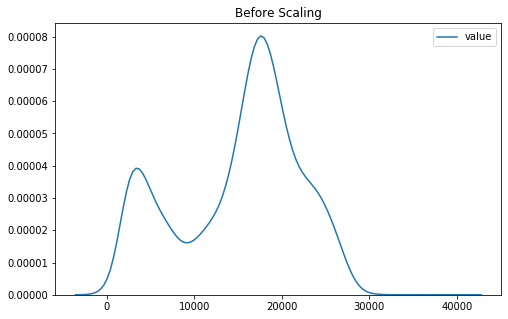

In [11]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])

df.head(5)

Shape: 8735


,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-08-01 00:30:00,17252,2014-08-01 00:30:00,4,8,0,0.440021
1,2014-08-01 01:00:00,14103,2014-08-01 01:00:00,4,8,1,0.359667
2,2014-08-01 01:30:00,10859,2014-08-01 01:30:00,4,8,1,0.276889
3,2014-08-01 02:00:00,9242,2014-08-01 02:00:00,4,8,2,0.235627
4,2014-08-01 02:30:00,7122,2014-08-01 02:30:00,4,8,2,0.181531


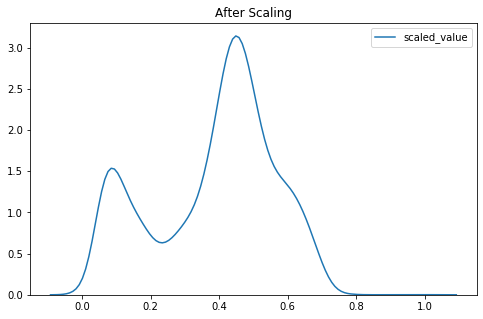

In [13]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [14]:
df.head(5)

,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-08-01 00:30:00,17252,2014-08-01 00:30:00,4,8,0,0.440021
1,2014-08-01 01:00:00,14103,2014-08-01 01:00:00,4,8,1,0.359667
2,2014-08-01 01:30:00,10859,2014-08-01 01:30:00,4,8,1,0.276889
3,2014-08-01 02:00:00,9242,2014-08-01 02:00:00,4,8,2,0.235627
4,2014-08-01 02:30:00,7122,2014-08-01 02:30:00,4,8,2,0.181531


In [15]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 64
n_features =4
n_steps_out =1
# split into samples
rawsequence = np.array(df[['scaled_value', 'dayofweek', 'month', 'hour']].values)
#rawsequence = np.array(df['scaled_value'])
trainsequence = rawsequence[0:training_points]
testsequence = rawsequence[training_points:]

X_train, y_train = split_sequence(trainsequence, n_steps, n_steps_out)
X_test, y_test = split_sequence(testsequence, n_steps, n_steps_out)
# summarize the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(rawsequence[0:12])
for i in range(2):
	print(X_train[i][0:4], y_train[i])

(3936, 64, 4) (3936, 1, 4)
(4671, 64, 4) (4671, 1, 4)
[[0.44002143 4.         8.         0.        ]
 [0.35966725 4.         8.         1.        ]
 [0.27688892 4.         8.         1.        ]
 [0.23562734 4.         8.         2.        ]] [[0.23823012 5.         8.         8.        ]]
[[0.35966725 4.         8.         1.        ]
 [0.27688892 4.         8.         1.        ]
 [0.23562734 4.         8.         2.        ]
 [0.18153053 4.         8.         2.        ]] [[0.25550537 5.         8.         9.        ]]


In [16]:
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)

(3936, 64, 4)
(3936, 64, 4)


In [17]:
print(y_train.shape)
#y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],n_features)
y_train = y_train.reshape(y_train.shape[0],n_features)
print(y_train.shape)

(3936, 1, 4)
(3936, 4)


In [18]:

input_layer = tf.keras.Input (shape = (n_steps, n_features))
conv_1 =  tf.keras.layers.Conv1D(filters=256, kernel_size=1, dilation_rate=1,
                padding='same', strides=1,input_shape=(n_steps, n_features),
                kernel_regularizer= tf.keras.regularizers.l2(0.01),
                activation='relu')(input_layer)

drop_1 =  tf.keras.layers.SpatialDropout1D(0.3)(conv_1)

conv_2 =  tf.keras.layers.Conv1D(filters=128, kernel_size=1, dilation_rate=1,
                padding='same',strides=1, kernel_regularizer= tf.keras.regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 =  tf.keras.layers.SpatialDropout1D(0.3)(conv_2)

conv_3 =  tf.keras.layers.Conv1D(filters=64, kernel_size=1, dilation_rate=1,
                padding='same', strides=1,kernel_regularizer= tf.keras.regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 =  tf.keras.layers.SpatialDropout1D(0.3)(conv_3)

conv_4 =  tf.keras.layers.Conv1D(filters=32, kernel_size=1, dilation_rate=1,
                padding='same', strides=1,kernel_regularizer= tf.keras.regularizers.l2(0.05),
                activation='relu')(drop_3)

flattened =  tf.keras.layers.Flatten()(conv_4)
dense =  tf.keras.layers.Dense(32)(flattened)
out =  tf.keras.layers.Dense(4)(dense)

model =  tf.keras.Model(input_layer, out)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='mse', metrics=['mse', 'accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           1280      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 64, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           32896     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 64)            8256      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 64, 64)            0     

In [19]:
from os.path import expanduser
home = expanduser("~")
home

'C:\\Users\\sridh'

In [20]:
logfilename = "tcn1"
batch_size=32
epochs=25

model.fit(x=X_train, y=y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, 
                       callbacks=[tf.keras.callbacks.TensorBoard(log_dir='{0}\logs\{1}'.format(home, logfilename))])

Train on 3936 samples
Epoch 1/25
3936/3936 [==============================] - 4s 963us/sample - loss: 11.0463 - mse: 7.3625 - accuracy: 0.8966
Epoch 2/25
3936/3936 [==============================] - 1s 151us/sample - loss: 5.6750 - mse: 2.8826 - accuracy: 0.9416
Epoch 3/25
3936/3936 [==============================] - 1s 151us/sample - loss: 4.0832 - mse: 1.8149 - accuracy: 0.9520
Epoch 4/25
3936/3936 [==============================] - 1s 149us/sample - loss: 3.2726 - mse: 1.3950 - accuracy: 0.9550
Epoch 5/25
3936/3936 [==============================] - 1s 152us/sample - loss: 2.5189 - mse: 0.9537 - accuracy: 0.9586
Epoch 6/25
3936/3936 [==============================] - 1s 161us/sample - loss: 1.9829 - mse: 0.6754 - accuracy: 0.9606
Epoch 7/25
3936/3936 [==============================] - 1s 162us/sample - loss: 1.6431 - mse: 0.5396 - accuracy: 0.9685
Epoch 8/25
3936/3936 [==============================] - 1s 165us/sample - loss: 1.4017 - mse: 0.4657 - accuracy: 0.9685
Epoch 9/25
3936/3

In [21]:
test1 = testsequence[:n_steps]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
print(test1.shape)
test1_pred = model.predict(x=test1)
print(testsequence[n_steps-2:n_steps+2])
print(test1_pred)

test1 = testsequence[128:n_steps+128]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
test1_pred = model.predict(x=test1)
print(testsequence[128+n_steps-2:128+n_steps+2])
print(test1_pred)

(64, 4)
(1, 64, 4)
[[ 0.41774478  4.         10.         15.        ]
 [ 0.38467427  4.         10.         16.        ]
 [ 0.37115007  4.         10.         16.        ]
 [ 0.4465794   4.         10.         17.        ]]
[[ 0.3726298  3.505049   9.38005   16.038536 ]]
(64, 4)
[[ 0.44650285  0.         10.          7.        ]
 [ 0.46178775  0.         10.          8.        ]
 [ 0.45033045  0.         10.          8.        ]
 [ 0.4527546   0.         10.          9.        ]]
[[ 0.5106785  -0.11753551  9.69397     7.9428496 ]]


In [22]:
y_pred = model.predict(x=X_test)
y_pred

array([[ 0.37262997,  3.5050488 ,  9.380049  , 16.038538  ],
       [ 0.43070444,  3.5899448 ,  9.397583  , 17.107595  ],
       [ 0.48206696,  3.5034761 ,  9.411724  , 17.121199  ],
       ...,
       [ 0.38903627,  1.7273793 ,  3.8942528 , 19.41347   ],
       [ 0.31178197,  1.5246447 ,  3.902237  , 20.267408  ],
       [ 0.3106111 ,  1.3662537 ,  3.8662317 , 19.872766  ]],
      dtype=float32)

In [23]:
y_test.shape = (y_test.shape[0], n_features)
y_test.shape

(4671, 4)

In [24]:

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.388


In [25]:

#testing_dataset = sequence
print("testing_dataset: ", y_test.shape)
print("testing_pred: ", y_pred.shape)

print(y_test[128:130:])
print(y_pred[128:130])
errors = y_test - y_pred
print(errors.shape)
print(errors[128:130])

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (4671, 4)
testing_pred:  (4671, 4)
[[ 0.45033045  0.         10.          8.        ]
 [ 0.4527546   0.         10.          9.        ]]
[[ 0.51067835 -0.11753535  9.693972    7.9428506 ]
 [ 0.47620007 -0.06623396  9.68712     8.823612  ]]
(4671, 4)
[[-0.0603479   0.11753535  0.30602837  0.05714941]
 [-0.02344547  0.06623396  0.31287956  0.17638779]]
Test RMSE: 1.388


RangeIndex(start=4000, stop=8735, step=1)
(4671, 4)
       eval
0  0.001480
1  0.015875
2  0.051323
3  0.032721
4  0.075601
RangeIndex(start=0, stop=4671, step=1)
                Datetime  scaled_value  dayofweek  month  hour
4000 2014-10-23 08:30:00      0.543341          3     10     8
4001 2014-10-23 09:00:00      0.523565          3     10     9
4002 2014-10-23 09:30:00      0.491031          3     10     9
4003 2014-10-23 10:00:00      0.464926          3     10    10
4004 2014-10-23 10:30:00      0.474495          3     10    10
(4735, 5)
(4735, 6)
             Datetime  scaled_value  dayofweek  month  hour      eval
0 2014-10-23 08:30:00      0.543341          3     10     8  0.001480
1 2014-10-23 09:00:00      0.523565          3     10     9  0.015875
2 2014-10-23 09:30:00      0.491031          3     10     9  0.051323
3 2014-10-23 10:00:00      0.464926          3     10    10  0.032721
4 2014-10-23 10:30:00      0.474495          3     10    10  0.075601
             Dateti

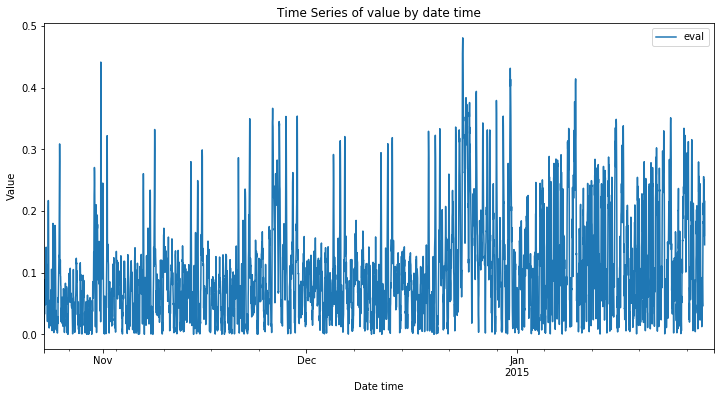

In [26]:
df2 = df.copy()
df2 = df2.loc[training_points:]
df2 = df2[['Datetime', 'scaled_value', "dayofweek", "month", "hour"]]
print(df2.index)

errorsDF = pd.DataFrame(errors, columns=['eval','edow','emonth','ehour'])
#errorsDF = pd.DataFrame(errors, columns=['a'])
print(errorsDF.shape)
errorsDF = errorsDF[['eval']]
errorsDF['eval'] = errorsDF['eval'].abs()
#errorsDF['predval']=scaler.inverse_transform(pd.DataFrame(errorsDF['predval']))
print(errorsDF.head(5))
print(errorsDF.index)

print(df2.head(5))
print(df2.shape)

df2.reset_index(drop=True, inplace=True)
errorsDF.reset_index(drop=True, inplace=True)

dfModified = pd.concat([df2, errorsDF], axis=1)
print(dfModified.shape)
print(dfModified.head(5))
dfModified.plot(x='Datetime', y='eval', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

df2 = dfModified[(dfModified.Datetime >= '2014-11-02') & (dfModified.Datetime < '2014-11-03')]
df2 = df2.reset_index(drop=True)
print(df2.head(5))

In [27]:
y_testDF = pd.DataFrame(y_test, columns=['val','origdow','origmonth','orighour'])
y_predDF = pd.DataFrame(y_pred, columns=['val','preddow','predmonth','predhour'])
y_testDF = y_testDF[['val']]
y_predDF = y_predDF[['val']]
#y_testDF['origval']=scaler.inverse_transform(pd.DataFrame(y_testDF['origval']))
#y_predDF['predval']=scaler.inverse_transform(pd.DataFrame(y_predDF['predval']))
print(y_testDF.head(5))
print(y_predDF.head(5))

        val
0  0.371150
1  0.446579
2  0.533389
3  0.585624
4  0.644288
        val
0  0.372630
1  0.430704
2  0.482067
3  0.552902
4  0.568687


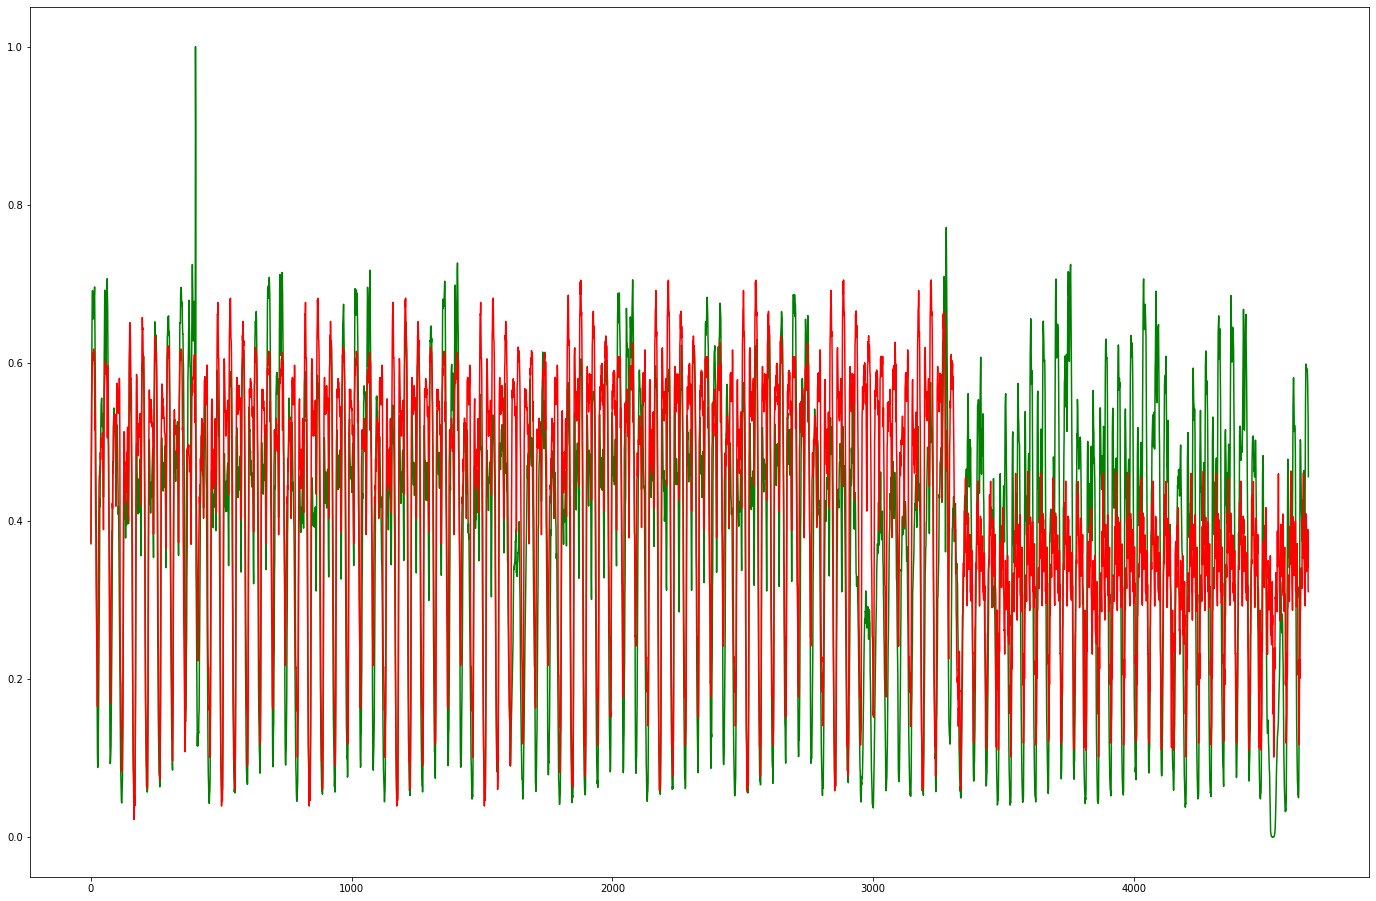

In [28]:
plt.figure(figsize=(24,16))
plt.plot(y_testDF, color='green')
plt.plot(y_predDF, color='red')

In [29]:
#based on cutoff after sorting errors
dist = np.linalg.norm(y_testDF - y_predDF, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.995 * len(scores))
print(cutoff)
print(scores[cutoff:])
threshold= scores[cutoff]


(4671,)
4647
[0.37277898 0.37596373 0.37730296 0.37931746 0.38259689 0.38326186
 0.38384423 0.38592928 0.38775836 0.39056954 0.39126633 0.39274176
 0.39409119 0.40250817 0.40701653 0.41367111 0.41432281 0.41919702
 0.43153861 0.43419832 0.44156176 0.45517008 0.46677244 0.48083516]


In [30]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=np.zeros(df.shape[0])
error = np.zeros(df.shape[0])
i=training_points+n_steps
print(i)
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label[i] = 1
    error[i] = dist
    i = i + 1
print(len(y_label))
print(len(error))

4064
8735
8735


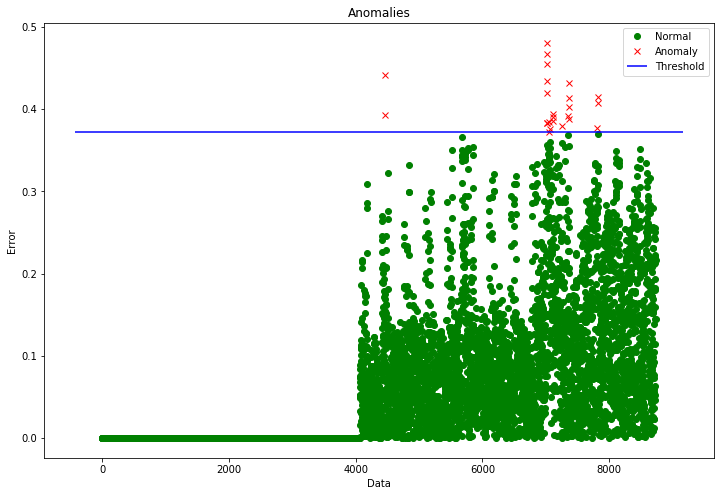

In [31]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [32]:
print(df.shape)
print(len(y_label))
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['scaled_value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


(8735, 7)
8735


,Datetime,observation,error,anomaly
0,2014-08-01 00:30:00,0.440021,0.0,0.0
1,2014-08-01 01:00:00,0.359667,0.0,0.0
2,2014-08-01 01:30:00,0.276889,0.0,0.0
3,2014-08-01 02:00:00,0.235627,0.0,0.0
4,2014-08-01 02:30:00,0.181531,0.0,0.0


Text(0.5, 1.0, 'Time Series of value by date time')

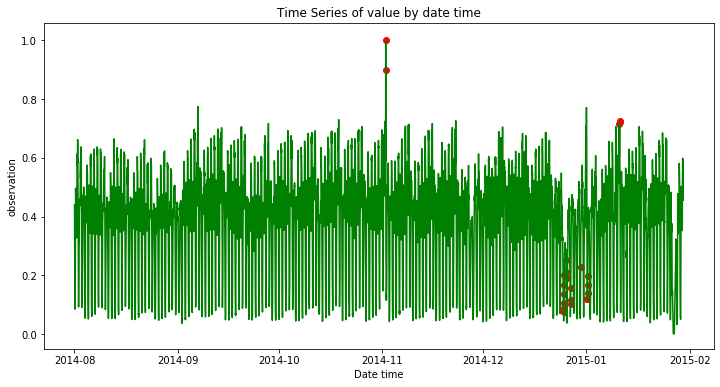

In [33]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')